In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import h5py
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import glob, json
from scipy.special import erf
import sys
sys.path.append('./../')
from support import *

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
posteriors_w190814 = np.load("./../../input/sampleDict_w190814.pickle",allow_pickle=True)
posteriors = posteriors_w190814.copy()
posteriors.pop('S190814bv')

posteriors_no190412 = posteriors.copy()
posteriors_no190412.pop('S190412m')

samps_no_evol = np.load('../output/processed_emcee_samples_plPeak_noEvol_r00.npy')
samps = np.load('./../output/processed_emcee_samples_plPeak_r00.npy')

n_catalogs = 750

In [3]:
# Load mock detections
ref_m_min = 2.
ref_m_max = 100.
ref_a1 = -2.35
ref_a2 = 2.

mMin = 5.

mockDetections = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/o3a_bbhpop_inj_info.hdf','r')
ifar_1 = mockDetections['injections']['ifar_gstlal'].value
ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
detected = (ifar_1>1) + (ifar_2>1) + (ifar_3>1)
m1_det = mockDetections['injections']['mass1_source'].value[detected]
m2_det = mockDetections['injections']['mass2_source'].value[detected]
s1z_det = mockDetections['injections']['spin1z'].value[detected]
s2z_det = mockDetections['injections']['spin2z'].value[detected]
z_det = mockDetections['injections']['redshift'].value[detected]

mockDetectionsO1O2 = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/injections_O1O2an_spin.h5','r')
m1_det = np.append(m1_det,mockDetectionsO1O2['mass1_source'])
m2_det = np.append(m2_det,mockDetectionsO1O2['mass2_source'])
s1z_det = np.append(s1z_det,mockDetectionsO1O2['spin1z'])
s2z_det = np.append(s2z_det,mockDetectionsO1O2['spin2z'])
z_det = np.append(z_det,mockDetectionsO1O2['redshift'])

# Derived quantities
q_det = m2_det/m1_det
X_det = (m1_det*s1z_det + m2_det*s2z_det)/(m1_det+m2_det)

ref_p_z = np.power(1.+z_det,2.-1.)
ref_p_m1 = np.power(m1_det,ref_a1)
ref_p_m2 = (1.+ref_a2)*np.power(m2_det,ref_a2)/(m1_det**(1.+ref_a2) - ref_m_min**(1.+ref_a2))

ref_p_xeff = np.zeros(X_det.size)
for i in range(ref_p_xeff.size):

    X = X_det[i]
    q = q_det[i]
    
    if X<-(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.+X)*(1.+q)/2.
        
    elif X>(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.-X)*(1.+q)/2.
        
    else:
        ref_p_xeff[i] = (1.+q)/2.

pop_reweight = 1./(ref_p_xeff*ref_p_m1*ref_p_m2*ref_p_z)
pop_reweight[m1_det<mMin] = 0.
pop_reweight[m2_det<mMin] = 0.

<ipython-input-3-d73ef177b37d>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_1 = mockDetections['injections']['ifar_gstlal'].value
<ipython-input-3-d73ef177b37d>:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
<ipython-input-3-d73ef177b37d>:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
<ipython-input-3-d73ef177b37d>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m1_det = mockDetections['injections']['mass1_source'].value[detected]
<ipython-input-3-d73ef177b37d>:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m2_det = mockDetections['injections']['mass2_source'].value[detected]
<ipython-input-3-d73ef177b37d>:16: H5pyDeprecationWarning: dataset.valu

In [8]:
def asym(x):
    return -np.exp(-x**2)/np.sqrt(np.pi)/x*(1.-1./(2.*x**2))

def calculate_Gaussian(x, mu, sigma2, low, high):
    a = (low-mu)/np.sqrt(2*sigma2)
    b = (high-mu)/np.sqrt(2*sigma2)
    norm = np.sqrt(sigma2*np.pi/2)*(-erf(a) + erf(b))

    # If difference in error functions produce zero, overwrite with asymptotic expansion
    norm = np.array(norm.reshape(-1))
    a = np.array(norm.reshape(-1))
    b = np.array(norm.reshape(-1))
    mu = np.array(mu.reshape(-1))
    sigma2 = np.array(sigma2.reshape(-1))
    if np.any(norm==0):
        badInds = np.where(norm==0)
        norm[badInds] = (np.sqrt(sigma2*np.pi/2)*(-asym(a) + asym(b)))[badInds]

    # If differences remain zero, then our domain of interest (-1,1) is so many std. deviations
    # from the mean that our parametrization is unphysical. In this case, discount this hyperparameter.
    # This amounts to an additional condition in our hyperprior
    # NaNs occur when norm is infinitesimal, like 1e-322, such that 1/norm is set to inf and the exponential term is zero
    y = (1.0/norm)*np.exp((-1.0*(x-mu)*(x-mu))/(2.*sigma2))
    if np.any(norm==0) or np.any(y!=y):
        return np.zeros(x.size)

    else:
        return y

In [5]:
mock_q_noEvol = np.zeros((len(posteriors),n_catalogs))
mock_x_noEvol = np.zeros((len(posteriors),n_catalogs))

resampled_q_noEvol = np.zeros((len(posteriors),n_catalogs))
resampled_x_noEvol = np.zeros((len(posteriors),n_catalogs))

mu_chi = np.zeros(n_catalogs)
logsig_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol.shape[0]))
    
    mMin = 5.
    lmbda = samps_no_evol[samp,0]
    mMax = samps_no_evol[samp,1]
    m0 = samps_no_evol[samp,2]
    sigM = samps_no_evol[samp,3]
    fPeak = samps_no_evol[samp,4]
    bq = samps_no_evol[samp,5]
    kappa = samps_no_evol[samp,6]
    mu0 = samps_no_evol[samp,7]
    logsig0 = samps_no_evol[samp,8]
    
    mu_chi[i] = mu0
    logsig_chi[i] = logsig0
    
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    
    try:
        detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=True)
        
    except ValueError:
        print(samp)
        
    mock_q_noEvol[:,i] = q_det[detected_injections]
    mock_x_noEvol[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol[ii,i] = qs[chosenInd]
        resampled_x_noEvol[ii,i] = chis[chosenInd]

In [81]:
obs_slope = np.zeros(n_catalogs)
obs_intercept = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)
mock_intercept = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    obs_intercept[i] = b
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m
    mock_intercept[i] = b
    
print(np.mean(obs_slope))

-0.0908555895562068


In [67]:
med_xs = np.median(resampled_x_noEvol,axis=1)
med_qs = np.median(resampled_q_noEvol,axis=1)
X = np.transpose([np.ones(med_qs.size),med_qs])
b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(med_xs)
median_slope = m
median_intercept = b
print(median_slope)

resorted_xs = np.copy(resampled_x_noEvol)
resorted_qs = np.copy(resampled_q_noEvol)
for i in range(n_catalogs):
    
    sorting = np.argsort(resorted_qs[:,i])
    resorted_xs[:,i] = resorted_xs[sorting,i]
    resorted_qs[:,i] = resorted_qs[sorting,i]
    
med_xs = np.median(resorted_xs,axis=1)
med_qs = np.median(resorted_qs,axis=1)
X = np.transpose([np.ones(med_qs.size),med_qs])
b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(med_xs)
median_resorted_slope = m
median_resorted_intercept = b
print(median_resorted_slope,b)

resortedx_xs = np.copy(resampled_x_noEvol)
resortedx_qs = np.copy(resampled_q_noEvol)
for i in range(n_catalogs):
    
    sorting = np.argsort(resortedx_xs[:,i])
    resortedx_xs[:,i] = resortedx_xs[sorting,i]
    resortedx_qs[:,i] = resortedx_qs[sorting,i]
    
med_xs = np.median(resortedx_xs,axis=1)
med_qs = np.median(resortedx_qs,axis=1)
X = np.transpose([np.ones(med_qs.size),med_qs])
b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(med_xs)
median_resortedx_slope = m
median_resortedx_intercept = b
print(median_resortedx_slope,b)

-0.22388849895235713
-0.09439933504040435 0.145874915367231
-4.121677540853642 3.48407989461083


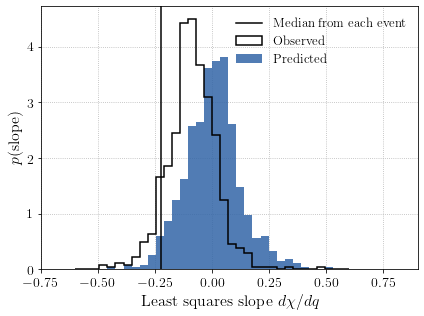

In [80]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_slope,label='Observed',bins=np.linspace(-0.6,0.6,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_slope,alpha=0.85,label='Predicted',bins=np.linspace(-0.6,0.6,35),color='#3265A7',density=True)
ax.set_xlim(-0.75,0.9)
ax.set_xlabel("Least squares slope $d\chi/dq$",fontsize=16)
ax.set_ylabel(r"$p(\mathrm{slope})$",fontsize=16)

ax.axvline(x=median_slope,color='black',label='Median from each event')
#ax.axvline(x=median_resorted_slope,color='black',ls='--',label='Median, resorted by q')
plt.legend(loc='upper right',fontsize=13,frameon=False)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

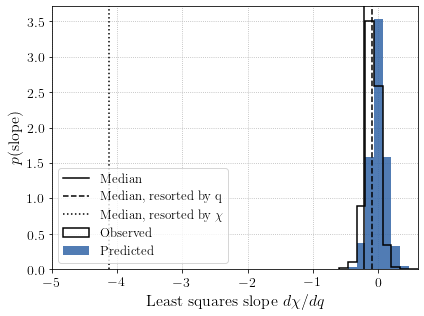

In [79]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_slope,label='Observed',bins=np.linspace(-0.6,0.6,10),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_slope,alpha=0.85,label='Predicted',bins=np.linspace(-0.6,0.6,10),color='#3265A7',density=True)
plt.legend(loc='upper left',fontsize=13,frameon=False)
ax.set_xlim(-5,0.6)
ax.set_xlabel("Least squares slope $d\chi/dq$",fontsize=16)
ax.set_ylabel(r"$p(\mathrm{slope})$",fontsize=16)

ax.axvline(x=median_slope,color='black',label='Median')
ax.axvline(x=median_resorted_slope,color='black',ls='--',label='Median, resorted by q')
ax.axvline(x=median_resortedx_slope,color='black',ls=':',label='Median, resorted by $\chi$')
plt.legend(loc='lower left',fontsize=13,frameon=True)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

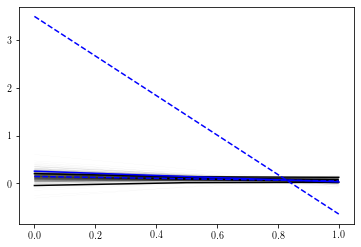

In [53]:
fig,ax = plt.subplots()

for i in range(n_catalogs):
    ax.plot(np.linspace(0,1,3),obs_slope[i]*np.linspace(0,1,3) + obs_intercept[i],color='black',lw=0.1,alpha=0.1)
    
mock_lines = np.zeros((3,n_catalogs))
for i in range(n_catalogs):
    mock_lines[:,i] = mock_slope[i]*np.linspace(0,1,3) + mock_intercept[i]
    
ax.plot(np.linspace(0,1,3),np.quantile(mock_lines,0.1,axis=1),color='black')
ax.plot(np.linspace(0,1,3),np.quantile(mock_lines,0.9,axis=1),color='black')

ax.plot(np.linspace(0,1,3),median_slope*np.linspace(0,1,3) + median_intercept,color='blue')
ax.plot(np.linspace(0,1,3),median_resorted_slope*np.linspace(0,1,3) + median_resorted_intercept,color='blue',ls='--')
ax.plot(np.linspace(0,1,3),median_resortedx_slope*np.linspace(0,1,3) + median_resortedx_intercept,color='blue',ls='--')

plt.show()

(0.0, 1.0)

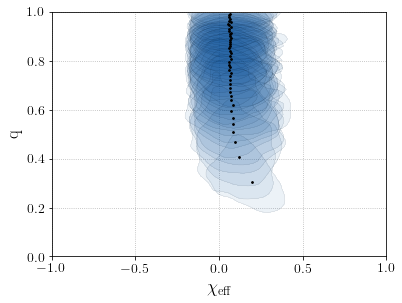

In [63]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(44):
    
    chis = resorted_xs[i,:]
    qs = resorted_qs[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

(0.0, 1.0)

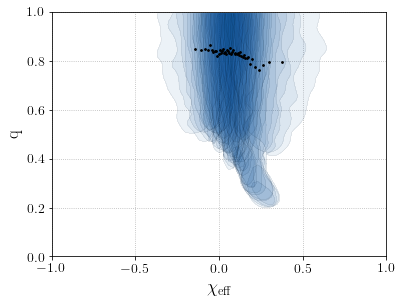

In [64]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(44):
    
    chis = resortedx_xs[i,:]
    qs = resortedx_qs[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

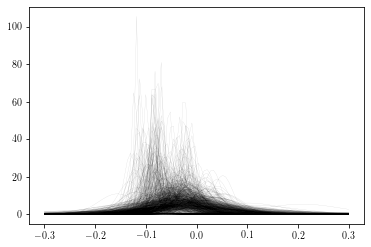

In [4]:
lmbda = samps[:,0]
mMax = samps[:,1]
m0 = samps[:,2]
sigM = samps[:,3]
fPeak = samps[:,4]
bq = samps[:,5]
kappa = samps[:,6]
mu0 = samps[:,7]
logsig0 = samps[:,8]
alpha = samps[:,9]
beta = samps[:,10]

fig,ax = plt.subplots()
for i in range(lmbda.size):
    
    ax.plot(np.linspace(-0.3,0.3,100),
            calculate_Gaussian(np.linspace(-0.3,0.3,100),
                               mu0[i] + alpha[i]*(1.-0.5),
                               10.**(2.*(logsig0[i] + beta[i]*(1.-0.5))),-1,1),
            color='black',lw=0.2,alpha=0.2)

(array([  9.,  33.,  64., 110., 181., 236., 190.,  78.,  21.,   6.]),
 array([-2.42283061, -2.23317592, -2.04352122, -1.85386653, -1.66421183,
        -1.47455713, -1.28490244, -1.09524774, -0.90559304, -0.71593835,
        -0.52628365]),
 <BarContainer object of 10 artists>)

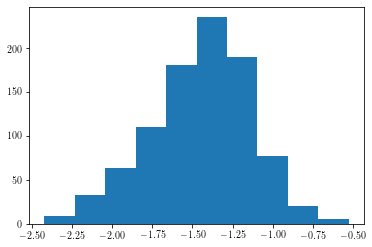

In [5]:
mus_at_q1 = mu0 + alpha*(1.-0.5)
logsigs_at_q1 = logsig0 + beta*(1.-0.5)
plt.hist(logsigs_at_q1)

(array([ 37.,  55., 102., 149., 170., 180., 132.,  99.,  56.,  20.]),
 array([-2.43955334, -2.07709065, -1.71462795, -1.35216526, -0.98970256,
        -0.62723987, -0.26477717,  0.09768552,  0.46014822,  0.82261091,
         1.18507361]),
 <BarContainer object of 10 artists>)

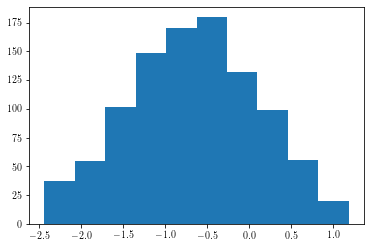

In [12]:
n_prior = 1000
mu0s_from_prior = np.random.random(n_prior)*2. - 1.
logsig0s_from_prior = np.random.random(n_prior)*2. - 1.5
alphas_from_prior = np.random.random(n_prior)*3.5 - 2.5
betas_from_prior = np.random.random(n_prior)*3.5 - 2.

plt.hist(logsig0s_from_prior + betas_from_prior*0.5)